In [1]:
import sys
sys.path.append("C:\\Users\josep\Desktop\sus_packages")
import help_tools1
from help_tools1 import polar_coordinates
from wave_tools import ConstructWave, surface_core, peak_tracking
import wave_tools
#import cv2
import h5py
from matplotlib import cm
#import radar_tools
import numpy as np
#from wave_tools import ConstructWave, surface_core, peak_tracking
#from wave_tools import fft_interpolate, fft_interface, Spectrum
#from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools1 import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools1 import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5'

# file with psi = 0 
#f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')


# file with psi = 30 and smax = 30 
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5', 'r')

In [3]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [4]:
eta.shape

(1200, 67, 67)

In [5]:
eta = np.transpose(eta, (1, 2, 0))
# flips it into correct form (N, N, M)

In [6]:
eta.shape

(67, 67, 1200)

In [7]:
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))

Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [8]:
Norm = dKx * dKy * dW

In [9]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 1) Find Dispersion Relation

### 1.1) Smooth Tapering

In [10]:
def tapering_function(n, a, L):
    if 0 <= n <= a * L / 2:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 1)))
    elif a * L / 2 <= n <= L * (1 - a / 2):
        return 1
    elif L * (1 - a / 2) <= n <= L:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 2 / a + 1)))
    else:
        return 0.0

def apply_tapering_3d(data, a):
    shape = data.shape
    tapering_3d = np.ones(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                tapering_3d[i, j, k] = tapering_function(i, a, shape[0]) * tapering_function(j, a, shape[1]) * tapering_function(k, a, shape[2])

    tapered_data = data * tapering_3d

    return tapered_data

In [11]:
a_value = 0.1

In [12]:
tapered_eta = apply_tapering_3d(eta, a_value)

In [13]:
tapered_padded_eta = np.pad(tapered_eta, ((30,31), (30,31), (0, 0)), 'constant',  constant_values=0)

In [14]:
tapered_padded_eta.shape

(128, 128, 1200)

In [15]:
# Taper Applied
Nx, Ny, Nt = tapered_padded_eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [16]:
# Taper Applied

# Get power spectra
Spectrum_raw = fftshift(fftn(tapered_padded_eta) / np.prod(tapered_padded_eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

### 1.2) HP Filter

In [17]:
I = power_Spectrum
I.shape

(128, 128, 1200)

In [18]:
w_cut = 0.03 * 2*np.pi

In [19]:
# Boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [20]:
I_1 = np.where(mask[ None, None,:], I, 0)

### 1.3) Energy Threshold Filter

In [21]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [22]:
I_2 = np.where(condition[:, :, None], I_1, 0)

### 1.4) Peak Identification 

In [23]:
def identification(kx, ky, ratio=10., prominence=1e5, distance=5):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        values = []

        if len(peaks) == 1:
            values.append(w[peaks[0]])
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    #thing.append(w[peaks[ind]])
                    wj[kx,ky] = w[peaks[ind][0]]
    
    return wj 

In [24]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=10., prominence=1e5, distance=15))

In [25]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [26]:
w0 = w0_2D[w0_2D != 0]

In [27]:
nonzero_indices = np.nonzero(w0_2D)

In [28]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [29]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.45 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.5, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        surf = axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th, surf

In [30]:
#%matplotlib widget

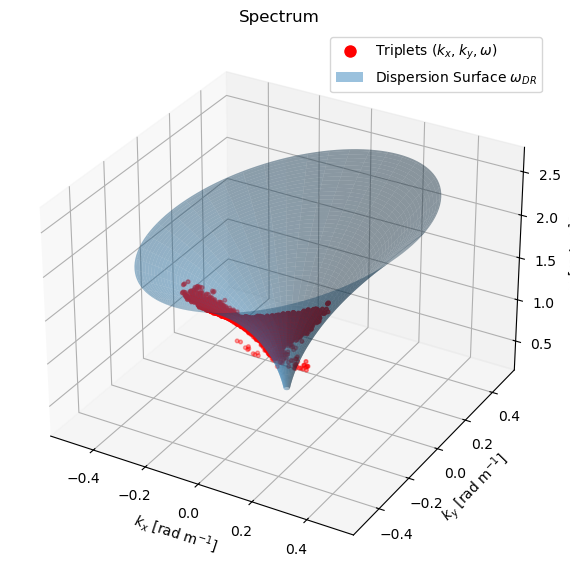

In [31]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0,  s = 7, color='red')
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th, surf = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0.52)

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets $(k_{x}, k_{y}, \omega)$'),
    mpatches.Patch( label='Dispersion Surface $\omega_{DR}$',  alpha=0.45)
]

# Create legendA
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

In [32]:
len(kx_trip)

2154

# 2) Least Squares Method

In [33]:
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

## 2.1) Initial Guess (0.2, 0.1)

In [34]:
-kx_trip, -ky_trip

(array([ 0.26179939,  0.26179939,  0.22907446, ..., -0.27488936,
        -0.27488936, -0.28143434]),
 array([-0.18980456, -0.19634954, -0.14398966, ..., -0.18980456,
        -0.19634954, -0.15707963]))

In [35]:
indices_trip_x = []
for elem in kx_trip:
    matching_indices_x = np.where(elem == Kx)[0]
    indices_trip_x.extend(matching_indices_x)

indices_trip_x = np.array(indices_trip_x)
# Indices of Kx/Ky where the triplets are the same

In [36]:
indices_trip_x

array([ 24,  24,  29, ..., 106, 106, 107], dtype=int64)

In [37]:
indices_trip_y = []
for elem in ky_trip:
    matching_indices_y = np.where(elem == Ky)[0]
    indices_trip_y.extend(matching_indices_y)

indices_trip_y = np.array(indices_trip_y)
# Indices of Kx/Ky where the triplets are the same

In [38]:
indices_trip_y

array([93, 94, 86, ..., 93, 94, 88], dtype=int64)

In [95]:
def find_velocity(kx,ky):
    # kx and ky are the indices 
    def objective_funct(U):
        Ux, Uy = U 
        return ( w0_2D[kx, ky] - np.sqrt(9.81*np.sqrt(Kx[kx]**2 + Ky[ky]**2)) - Kx[kx]*Ux - Ky[ky]*Uy )**2

    initial_guess = [0.2,0.1]
    
    result = minimize(objective_funct, initial_guess, method='BFGS')
    
    # Extract the optimized values of Ux and Uy
    Ux_optimized, Uy_optimized = result.x
    
    return Ux_optimized, Uy_optimized, np.sqrt(Kx[kx]**2 + Ky[ky]**2), result.fun

In [96]:
U_x = []
U_y = []
k_vals = []
Q = []

# Define total number of iterations
total_iterations = len(indices_trip_x)

# Create tqdm instance to track progress
progress_bar = tqdm(total=total_iterations, desc="Processing")

for i in range(len(indices_trip_x)):
    # Update progress bar
    progress_bar.update(1)
        
    if np.max(I_2[indices_trip_x[i], indices_trip_y[i],:]) < 0.0*np.max(I_2):
        pass
        
    else:
        result = find_velocity(indices_trip_x[i], indices_trip_y[i])
        U_x.append(result[0])
        U_y.append(result[1])
        k_vals.append(result[2])
        Q.append(result[3])

# Close progress bar
progress_bar.close()

Processing: 100%|██████████| 2154/2154 [00:26<00:00, 81.92it/s]


In [56]:
%matplotlib inline

(0.0, 1.0)

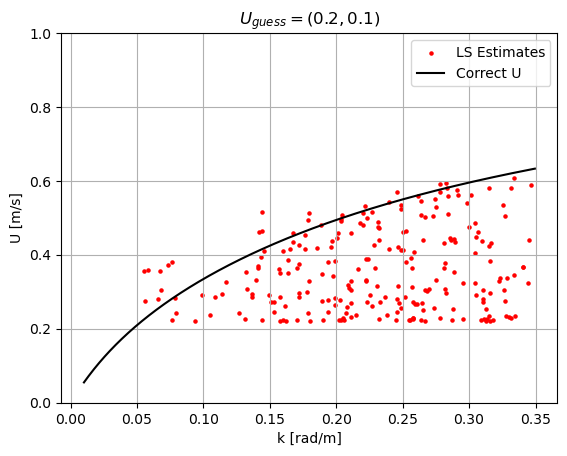

In [98]:
plt.scatter(k_vals[::9], np.sqrt((np.array(U_x))**2+(np.array(U_y))**2)[::9], label='LS Estimates', color = 'red', s = 5)
plt.plot(k, Uk[:,0], label='Correct U', color = 'black')

plt.ylabel("U [m/s]")
plt.xlabel("k [rad/m]")
plt.title("$U_{guess}=(0.2,0.1)$")

plt.grid(True)
plt.legend()
plt.ylim(0,1)

## 2.2) Initial Guess is correct velocities

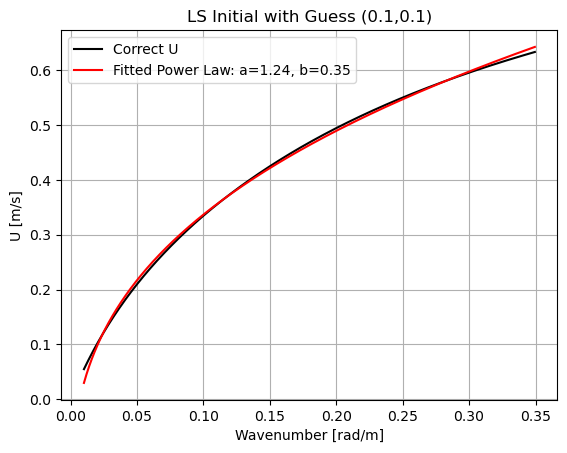

In [99]:
# Function to fit (power law)
def power_law(x, a, b, c):
    return a * x**b +c

# initial guess
pars0 = (1.2, 0.35, -0.2)

# Fit the power law to the data
popt, pcov = curve_fit(power_law, k, Uk[:, 0],  absolute_sigma=True, p0=pars0)

a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

b_opt = popt[1]
b_opt_err = np.sqrt(pcov[1, 1])

c_opt = popt[2]
c_opt_err = np.sqrt(pcov[2, 2])

# Plot original data
plt.plot(k, Uk[:, 0], label='Correct U', color='black')

# Plot fitted power law
plt.plot(k, power_law(k, *popt), label=f'Fitted Power Law: a={popt[0]:.2f}, b={popt[1]:.2f}', color='red')

plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS Initial with Guess (0.1,0.1)")

plt.grid(True)
plt.legend()

In [100]:
def U_shear(x):
    return a_opt*x**b_opt + c_opt 

In [101]:
def find_velocity(kx,ky):
    # kx and ky are the indices 
    def objective_funct(U):
        Ux, Uy = U 
        return ( w0_2D[kx, ky] - np.sqrt(9.81*np.sqrt(Kx[kx]**2 + Ky[ky]**2)) - Kx[kx]*Ux - Ky[ky]*Uy )**2

    initial_guess = [U_shear(np.sqrt(Kx[kx]**2 + Ky[ky]**2))  * np.cos(math.radians(30))  , 
                     U_shear(np.sqrt(Kx[kx]**2 + Ky[ky]**2)) * np.sin(math.radians(30)) ] 
    
    result = minimize(objective_funct, initial_guess, method='BFGS')
    
    # Extract the optimized values of Ux and Uy
    Ux_optimized, Uy_optimized = result.x
    
    return Ux_optimized, Uy_optimized, np.sqrt(Kx[kx]**2 + Ky[ky]**2), result.fun

In [102]:
U_x = []
U_y = []
k_vals = []
Q = []

# Define total number of iterations
total_iterations = len(indices_trip_x)

# Create tqdm instance to track progress
progress_bar = tqdm(total=total_iterations, desc="Processing")

for i in range(len(indices_trip_x)):
    # Update progress bar
    progress_bar.update(1)
        
    if np.max(I_2[indices_trip_x[i], indices_trip_y[i],:]) < 0.0*np.max(I_2):
        pass
        
    else:
        result = find_velocity(indices_trip_x[i], indices_trip_y[i])
        U_x.append(result[0])
        U_y.append(result[1])
        k_vals.append(result[2])
        Q.append(result[3])

# Close progress bar
progress_bar.close()

Processing: 100%|██████████| 2154/2154 [00:25<00:00, 83.12it/s]


(0.0, 1.0)

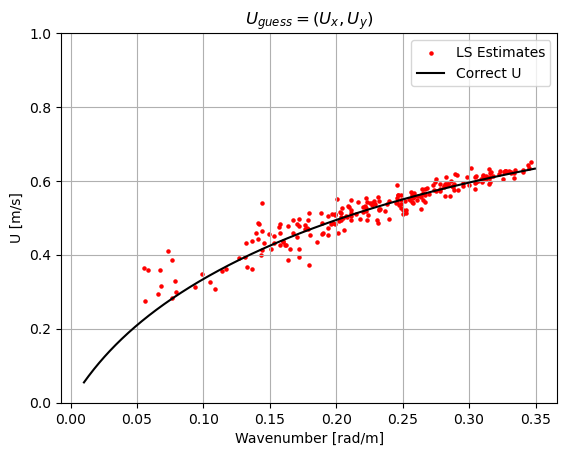

In [104]:
plt.scatter(k_vals[::9], np.sqrt((np.array(U_x))**2+(np.array(U_y))**2)[::9], label='LS Estimates', color = 'red', s = 5)
plt.plot(k, Uk[:,0], label='Correct U', color = 'black')

plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("$U_{guess}=(U_x,U_y)$")

plt.grid(True)
plt.legend()
plt.ylim(0,1)